# Advanced Tutorial: Multi-Panel Integration and Downstream Analysis with CytoVI

In this tutorial, we demonstrate advanced functionality of **CytoVI**, a deep generative model for protein expression measurements from technologies such as flow cytometry, mass cytometry, or CITE-seq. Building on the quick start tutorial, we now explore how CytoVI can be used to integrate multiple cytometry panels, impute missing markers, transfer annotations between datasets, and uncover biological differences through differential expression and abundance analysis.

If you are new to CytoVI or unfamiliar with data loading, preprocessing, or training the model, we recommend starting with the [quick start tutorial](#) where these fundamental steps are introduced in detail. In this tutorial, we will work with preprocessed and partially annotated data to focus on the advanced use cases of the model.

Specifically, we analyze conventional flow cytometry data of tumor-infiltrating T cells obtained from patients with B-cell non-Hodgkin lymphoma (BNHL) These samples were profiled using two distinct antibody panels, which share a subset of common markers. Using CytoVI, we will integrate both panels into a shared representation space, infer missing marker expression, and perform downstream biological analysis to gain insights into T cell heterogeneity across patients.

Plan for this tutorial:

1. Load and inspect preprocessed data
2. Train a CytoVI model that integrates both antibody panels
3. Visualize the joint latent space and evaluate panel integration
4. Impute non-overlapping protein markers and assess imputation quality
5. Automatically annotate immune cell types via label transfer
6. Quantify differential protein expression across conditions or clusters
7. Detect disease-associated T cell states using label-free differential abundance analysis

In [ ]:
# Install from GitHub for now
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [1]:
import os
import random
import tempfile
import requests
import scvi

import numpy as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import scanpy as sc  # type: ignore
from scvi.external import cytovi # type: ignore
import torch  # type: ignore
from rich import print  # type: ignore

sc.set_figure_params(figsize=(4, 4))

scvi.settings.seed = 0
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.2

## Loading the data

In this tutorial, we will work with a curated, lightweight subset of flow cytometry data from the BNHL study by Roider et al. 2024 (Nature Cell Biology, https://doi.org/10.1038/s41556-024-01358-2). The dataset includes flow cytometry measurements of T cells from 33 donors across two distinct antibody panels, each profiling 12 protein markers along with morphological features such as forward and side scatter (FSC and SSC). Samples were acquired across four independent experimental batches. For ease of use, the data have been preprocessed to correct for fluorescent spillover, restricted to live single-cell events, and transformed using a hyperbolic arcsin transformation, scaled and subsampled to ~5000 cells per panel. We will access the dataset as preprocessed .h5ad files. For demonstration purposes data from one of the panels comes with cell type annotations.

In [6]:
temp_dir_obj = tempfile.TemporaryDirectory()

adata_p1_path = os.path.join(temp_dir_obj.name, "Roider_et_al_BNHL_panel1.h5ad")
adata_p1 = sc.read(adata_p1_path, backup_url='https://figshare.com/ndownloader/files/56891468')

adata_p2_path = os.path.join(temp_dir_obj.name, "Roider_et_al_BNHL_panel2.h5ad")
adata_p2 = sc.read(adata_p2_path, backup_url='https://figshare.com/ndownloader/files/56891471')

  0%|          | 0.00/2.42M [00:00<?, ?B/s]

  0%|          | 0.00/1.89M [00:00<?, ?B/s]

In [13]:
adata_p1

AnnData object with n_obs × n_vars = 4983 × 14
    obs: 'sample_id', 'PatientID', 'batch', 'panel', 'Entity', 'cell_type'
    layers: '_nan_mask', 'raw', 'scaled', 'transformed'

As the data has been preprocessed already, we can directly merge the two panels into one anndata object using `cytovi.merge_batches()`. This will automatically register a `nan_layer` that will handle the modeling of missing markers under the hood.

In [14]:
adata = cytovi.merge_batches([adata_p1, adata_p2], batch_key='panel_batch')
adata

/tmp/ipykernel_32032/3116451448.py:1: UserWarning: Not all proteins are detected across all batches. Will generate nan_layer for imputation of missing proteins. 
Backbone markers: CD3, CD4, CD45RA, CD69, CD8, FSC-A, FoxP3, Ki67, PD1, SSC-A
  adata = cytovi.merge_batches([adata_p1, adata_p2], batch_key='panel_batch')
/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_preprocessing.py:255: UserWarning: Masking layer _nan_mask already exists. Overwriting it.
  adata = register_nan_layer(


AnnData object with n_obs × n_vars = 9966 × 18
    obs: 'sample_id', 'PatientID', 'batch', 'panel', 'Entity', 'cell_type', 'panel_batch'
    var: '_batch_0', '_batch_1'
    layers: '_nan_mask', 'raw', 'scaled', 'transformed'

Inspection of the histograms for each marker demonstrates that some proteins, such as CD4, CD3, CD45RA, CD69, were detected in both antibody panels, while four markers were unique in batch one (e.g. CD25, CXCR5) and four additional markers were unique for batch two (e.g. CD244 and TIM-3).

In [ ]:
cytovi.plot_histogram(adata, layer_key='scaled', groupby='panel')

Additionally, we see that CD69 demonstrates a batch effect in one of the four batches.

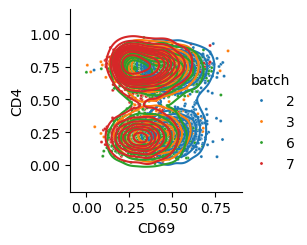

In [125]:
cytovi.plot_biaxial(adata, marker_x='CD69', marker_y='CD4', layer_key='scaled', color='batch')

## Training a CytoVI model

In the next step, we will train a CytoVI model to control for technical variation between the batches. As our dataset consists of multiple patients of different B cell lymphoma diagnoses, we will additionally specify a `sample_key`, which will be used for downstream application such as performing differential expression across patients or for the identification of disease-associated T cell states. If using CytoVI's `cytovi.merge_batches` function to combine both panels, CytoVI will automatically register a `nan_layer` and handle imputation of missing proteins. In this case onyl the shared backbone markers are encoded into the latent representation, while the decoder network reconstructs the full protein panel.

In [ ]:
cytovi.CYTOVI.setup_anndata(adata, layer='scaled', batch_key='batch', sample_key='PatientID')
model = cytovi.CYTOVI(adata)
model.train(n_epochs_kl_warmup=50)

In [128]:
model

CytoVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, 
protein_likelihood: normal, latent_distribution: normal, 
MoG prior: True, n_labels 1, n_proteins: 18, 
Impute missing markers: True, 
Backbone markers: CD3, CD4, CD45RA, CD69, CD8, FSC-A, FoxP3, Ki67, PD1, SSC-A
Training status: Trained

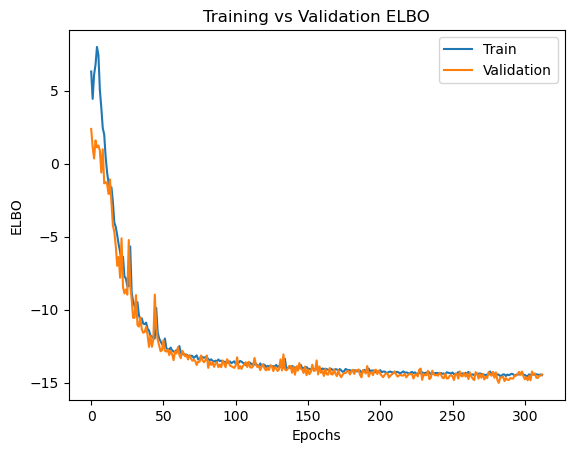

In [127]:
plt.plot(model.history['elbo_train'], label='Train')
plt.plot(model.history['elbo_validation'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.title('Training vs Validation ELBO')
plt.show()

## Visualize the joint latent space

Next, we get the latent representation of our cells while controlling for batch and panel variation and visualize the joint latent space using UMAP.

/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: FutureWarning: `method='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  return fn(*args_all, **kw)


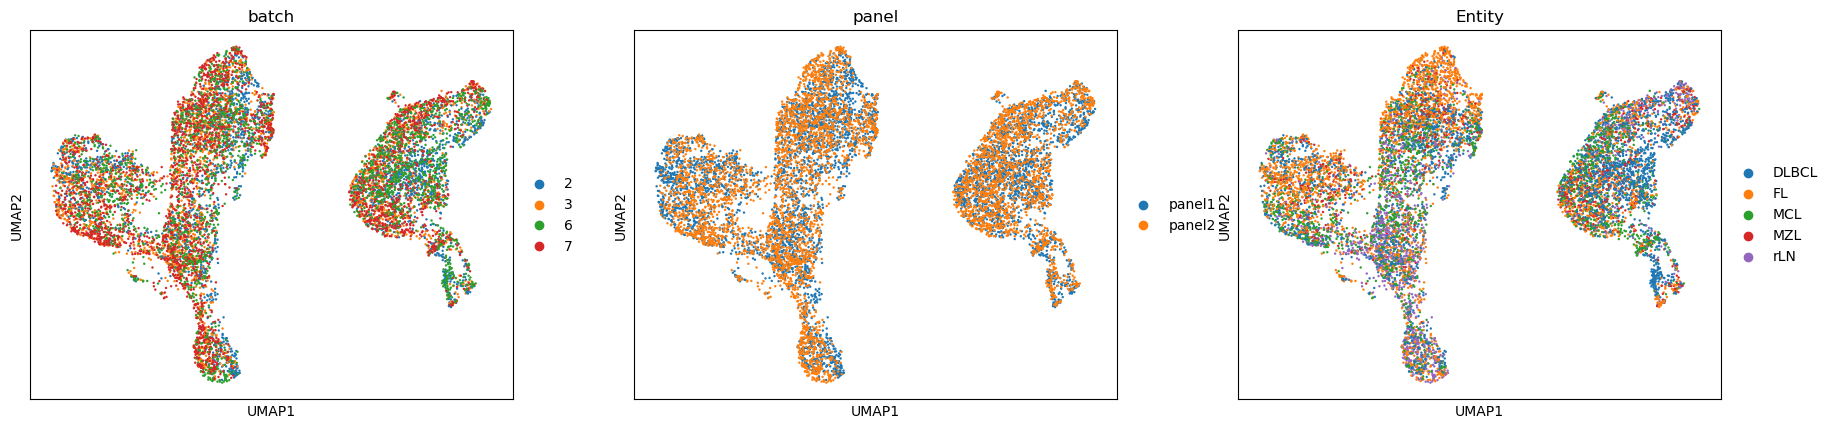

In [133]:
adata.obsm['X_CytoVI'] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep='X_CytoVI', transformer='pynndescent')
sc.tl.umap(adata, method = 'rapids', min_dist=0.4)
sc.pl.umap(adata, color = ['batch', 'panel', 'Entity'])

We can see that this latent representation effectively controlled for batch and panel variation and yielded a cell representation that still maintains the variability between the different disease entities.

## Impute non-overlapping protein markers

Next, we obtain the batch corrected protein expression from the CytoVI model that automatically imputes non-overlapping protein markers. Here, we will sample ten times from the posterior distribution and generate the imputed protein expression ten times in order to assess the imputation uncertainty. We take the mean over these ten samples as our estimate for the imputed protein expression.

In [ ]:
imp_expr = model.get_normalized_expression(n_samples=10, return_mean = False)
adata.layers['imputed'] = imp_expr.mean(axis=0).copy()

The visualization now shows the complete imputed protein expression for all proteins present in the combined set of the two antibody panels. Additionally, we can now query markers that were unique for each of the panels, and display for example the expression of the costimulatory protein CD244 versus the IL-2 high affinity chain CD25.

In [ ]:
cytovi.plot_histogram(adata, layer_key='imputed', groupby='panel')

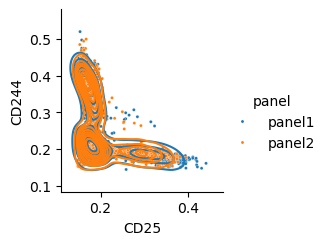

In [136]:
cytovi.plot_biaxial(adata, marker_x='CD25', marker_y='CD244', layer_key='imputed', color='panel')

Next, we compute the coefficient of variation across the ten imputed expression estimates of the posterior samples and visualize the uncertainty across the cell and feature axes to judge imputation performance.

In [ ]:
adata.layers['imputed_cv'] = 100*imp_expr.std(axis=0).copy()/imp_expr.mean(axis=0).copy()

adata.var['var_imp_uncertainty'] = adata.layers['imputed_cv'].mean(axis=0).copy()
adata.obs['obs_imp_uncertainty'] = adata.layers['imputed_cv'].mean(axis=1).copy()

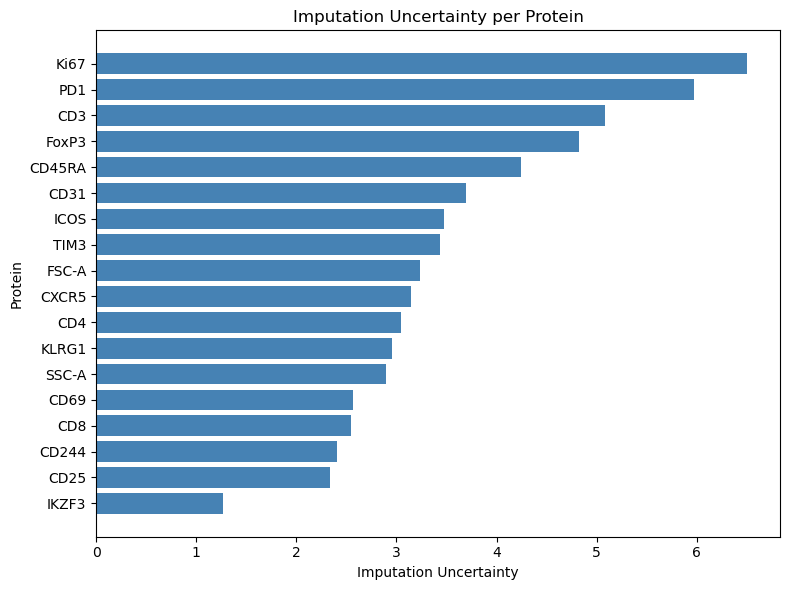

In [147]:
uncertainty = adata.var['var_imp_uncertainty'].sort_values()

plt.figure(figsize=(8, 6))
plt.barh(uncertainty.index, uncertainty.values, color="steelblue")
plt.xlabel("Imputation Uncertainty")
plt.ylabel("Protein")
plt.title("Imputation Uncertainty per Protein")
plt.tight_layout()
plt.show()

This analysis demonstrated that the model was less certain when imputing Ki67 expression 

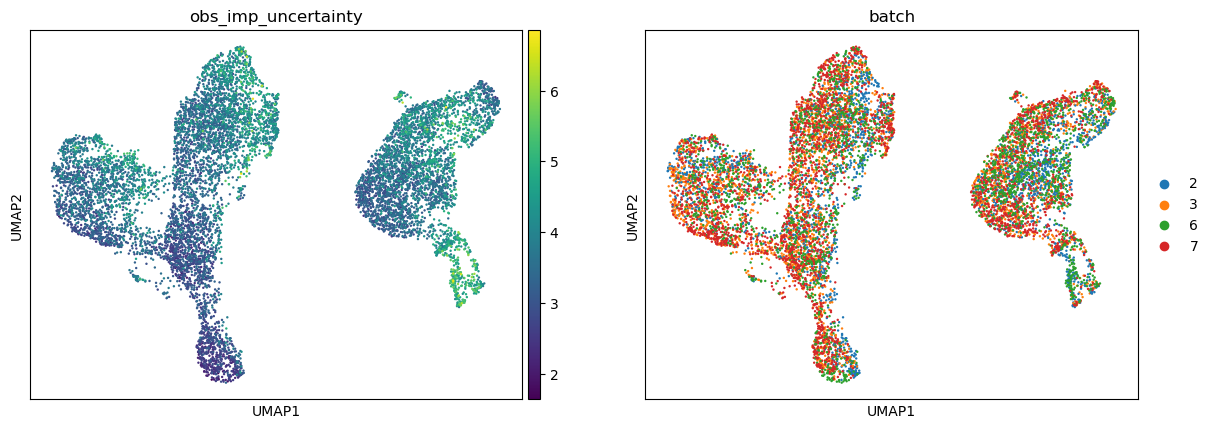

In [144]:
sc.pl.umap(adata, color = ['obs_imp_uncertainty', 'batch'])

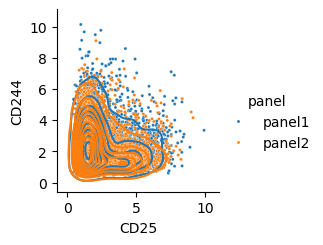

In [143]:
cytovi.plot_biaxial(adata, marker_x='CD25', marker_y='CD244', layer_key='imputed_cv', color='panel')

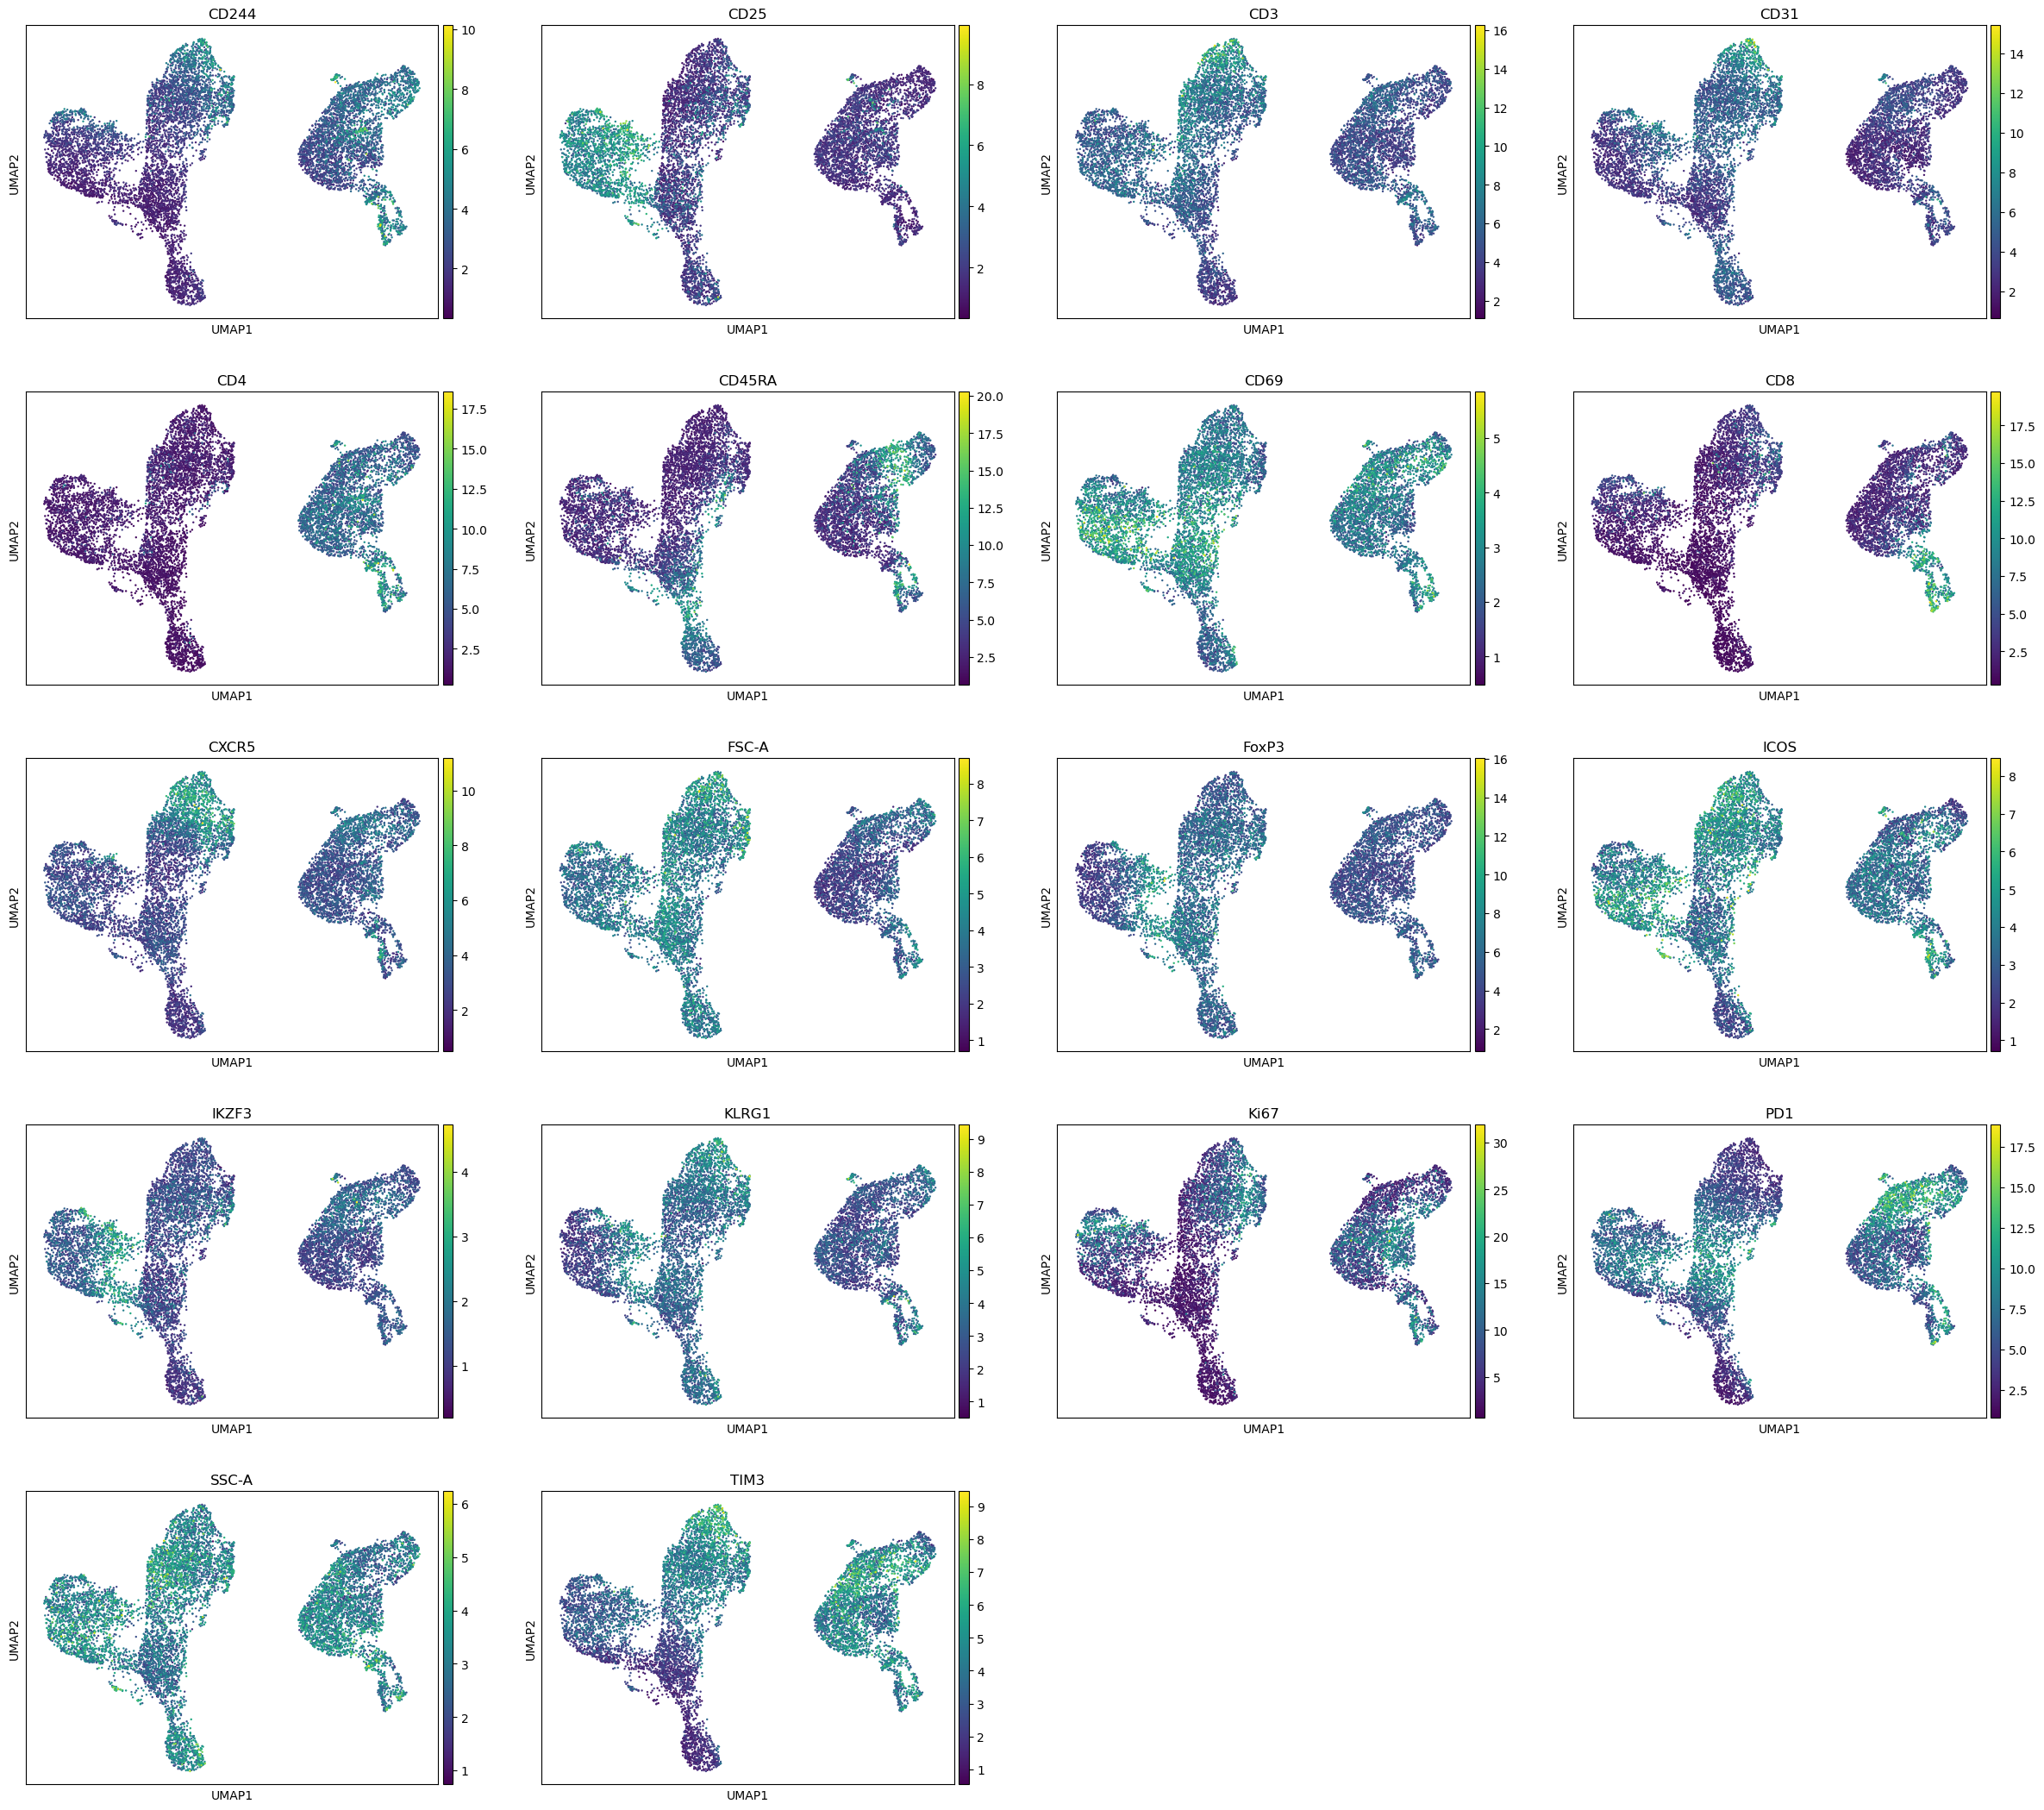

In [140]:
sc.pl.umap(adata, color=adata.var_names, layer='imputed_cv')

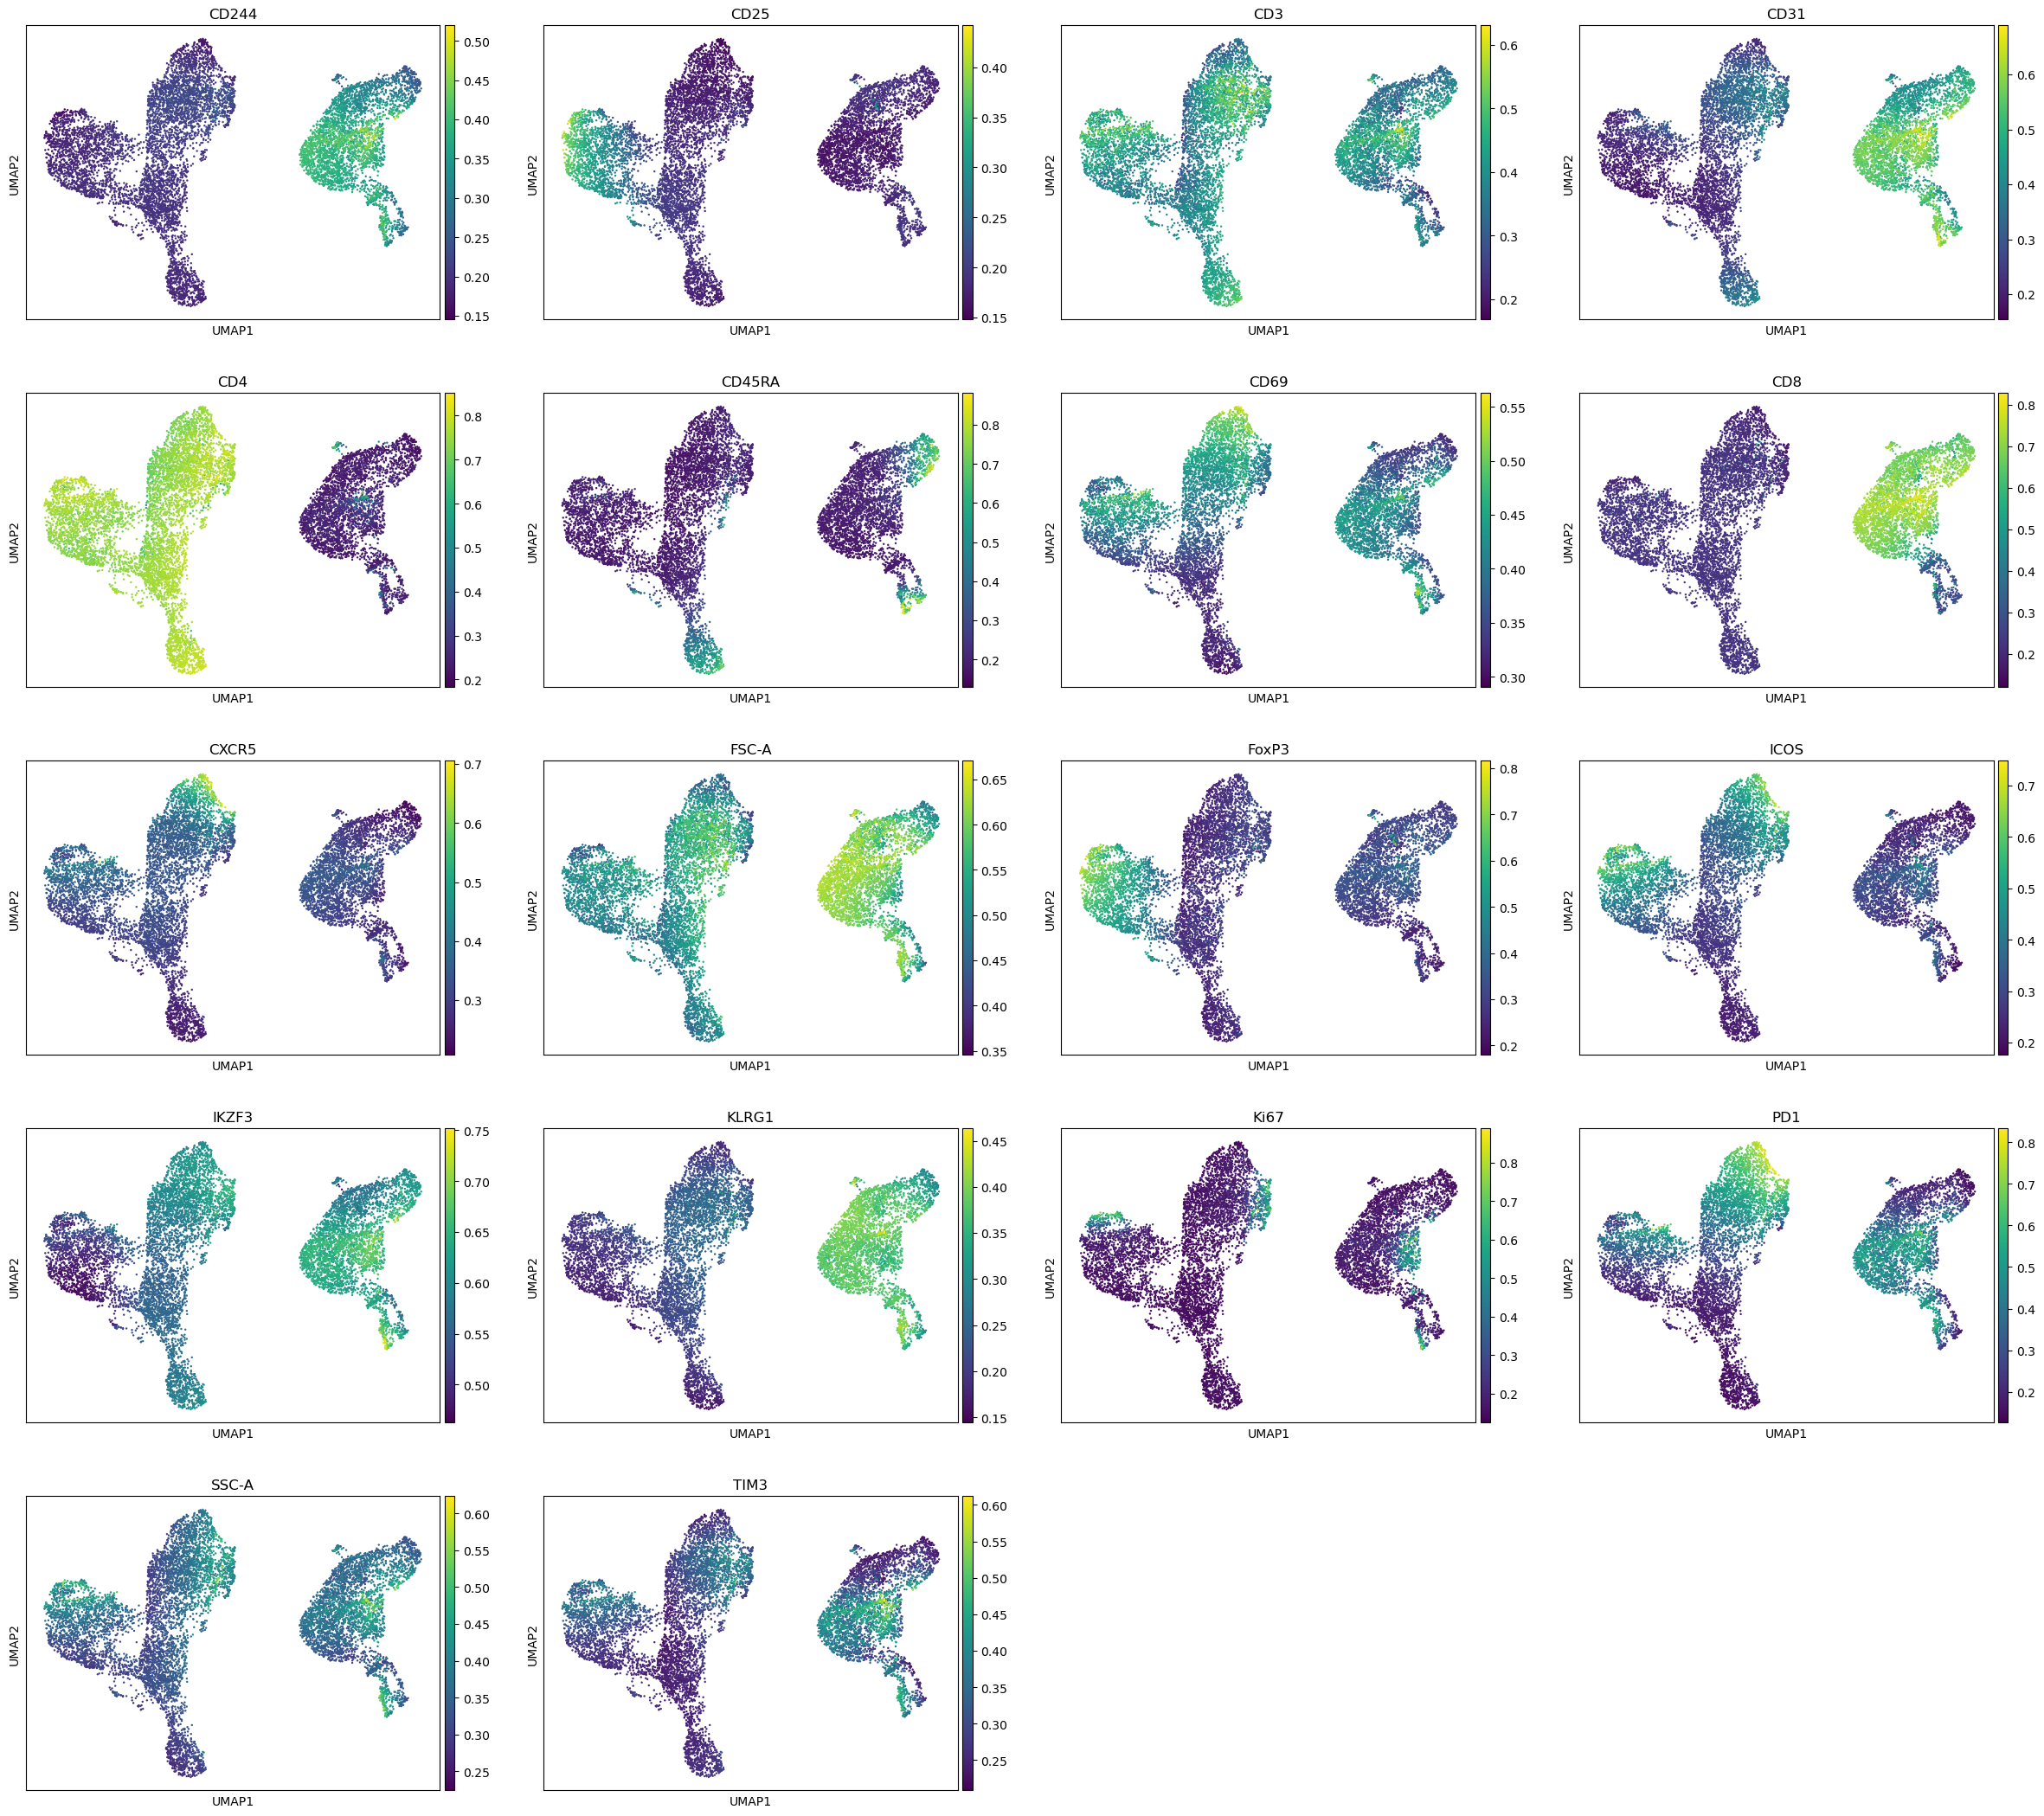

In [141]:
sc.pl.umap(adata, color=adata.var_names, layer='imputed')